# MSDS 604 Final Project
## Zillow Home Sell Price Predictions
### Andy Cheon, Roja Immanni, Lin Meng, Kevin Wong
### December 11, 2019

---

Below is the combined code of each group member's data analysis.  It includes all EDA, differencing, and code to generate the best model according to RMSE.

In [31]:
reset -fs

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

%config InlineBackend.figure_format = 'svg'

## EDA

In [33]:
df = pd.read_csv('../data/zillow-california.csv', parse_dates=['Date'])

In [34]:
sellprice = df['MedianSoldPrice_AllHomes.California']
sellprice.index = pd.DatetimeIndex(df['Date'])

In [35]:
sellprice_not_na = sellprice[~sellprice.isna()]

### Read, visualize raw data

In [36]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

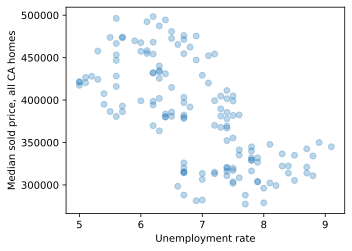

In [37]:
plt.figure(figsize=(5, 3.8))
plt.scatter(df['UnemploymentRate'], df['MedianSoldPrice_AllHomes.California'], alpha=0.3)
plt.xlabel('Unemployment rate')
plt.ylabel('Median sold price, all CA homes')
plt.show()

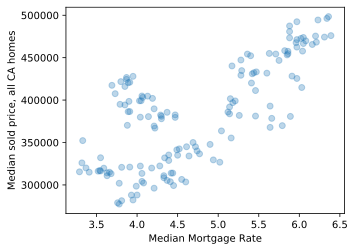

In [38]:
plt.figure(figsize=(5, 3.8))
plt.scatter(df['MedianMortageRate'], df['MedianSoldPrice_AllHomes.California'], alpha=0.3)
plt.xlabel('Median Mortgage Rate')
plt.ylabel('Median sold price, all CA homes')
plt.show()

Correlations:
  - median mortgage rate
  - unemployment rate

In [39]:
sellprice = df['MedianSoldPrice_AllHomes.California']
sellprice.index = pd.DatetimeIndex(df['Date'])
sellprice.head()

Date
2004-01-31    326752.55
2004-02-29    329501.50
2004-03-31    340125.45
2004-04-30    355329.50
2004-05-31    367818.15
Name: MedianSoldPrice_AllHomes.California, dtype: float64

In [40]:
sellprice_not_na = sellprice[~sellprice.isna()]

#### Line, ACF plots

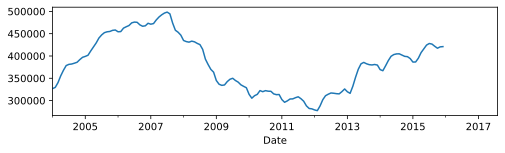

In [41]:
plt.figure(figsize=(8, 2))
sellprice.plot()
# plt.xticks(rotation=45)
plt.show()

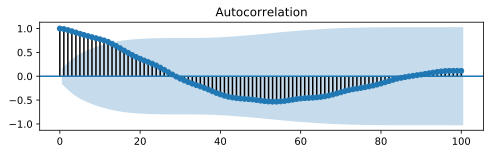

In [42]:
fig = plot_acf(sellprice_not_na, lags=100)
fig.set_size_inches(8, 2)
plt.show()

### Differencing

#### 1-time trend differencing

In [43]:
sellprice_d1 = pd.Series(np.diff(sellprice_not_na.values, n=1),
                           index=sellprice_not_na.index[1:])

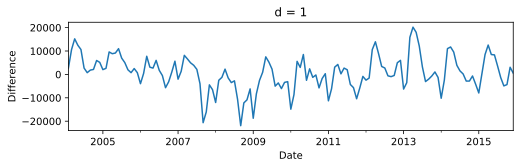

In [44]:
plt.figure(figsize=(8, 2))
sellprice_d1.plot()
plt.ylabel('Difference')
plt.title('d = 1')
plt.show()

In [45]:
adf_test(sellprice_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### 2-time trend differencing

In [46]:
sellprice_d2 = pd.Series(np.diff(sellprice_not_na.values, n=2),
                           index=sellprice_not_na.index[2:])

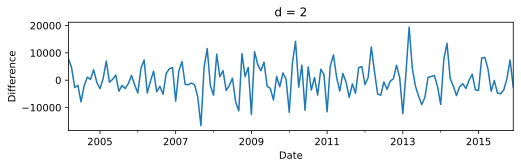

In [47]:
plt.figure(figsize=(8, 2))
sellprice_d2.plot()
plt.ylabel('Difference')
plt.title('d = 2')
plt.show()

In [48]:
adf_test(sellprice_d2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### 3-time trend differencing

In [49]:
sellprice_d3 = pd.Series(np.diff(sellprice_not_na.values, n=3),
                           index=sellprice_not_na.index[3:])

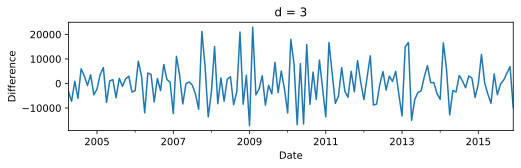

In [50]:
plt.figure(figsize=(8, 2))
sellprice_d3.plot()
plt.ylabel('Difference')
plt.title('d = 3')
plt.show()

In [51]:
adf_test(sellprice_d3)

Results of Dickey-Fuller Test:
Test Statistic                -7.368268e+00
p-value                        9.114125e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.260000e+02
Critical Value (1%)           -3.483346e+00
Critical Value (5%)           -2.884766e+00
Critical Value (10%)          -2.579156e+00
dtype: float64


#### 1-time seasonal differencing on 2-time trend differencing

There appears to be slight seasonality with lag 12, according to the 1-time differencing line plot.

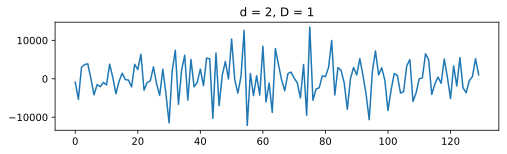

In [52]:
sellprice_d2_D1 = []
for i in range(12, len(sellprice_d2)):
    value = sellprice_d2[i] - sellprice_d2[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D1.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 1')
plt.plot(sellprice_d2_D1) 
plt.show()

In [53]:
adf_test(sellprice_d2_D1)

Results of Dickey-Fuller Test:
Test Statistic                  -5.149454
p-value                          0.000011
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


#### 2-time seasonal differencing on 2-time trend differencing

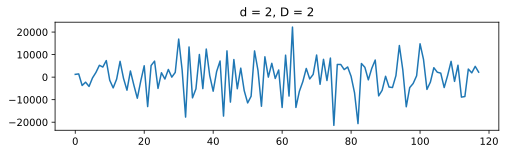

In [54]:
sellprice_d2_D2 = []
for i in range(12, len(sellprice_d2_D1)):
    value = sellprice_d2_D1[i] - sellprice_d2_D1[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D2.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 2')
plt.plot(sellprice_d2_D2) 
plt.show()

In [55]:
adf_test(sellprice_d2_D2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.224150
p-value                          0.000008
#Lags Used                      13.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


---

## Best SARIMA-class model

### d = 1, D = 2

In [56]:
train_size = int(len(sellprice_not_na) * 0.80)
train, valid = sellprice_not_na[:train_size], sellprice_not_na[train_size:]
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [57]:
model_d1_D2 = pm.auto_arima(train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=2, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1807.452, BIC=1819.951, Fit time=0.973 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=1887.649, BIC=1892.649, Fit time=0.028 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=1896.124, BIC=1906.124, Fit time=0.288 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1841.415, BIC=1851.414, Fit time=0.208 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=1825.971, BIC=1840.970, Fit time=0.503 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=1894.700, BIC=1904.699, Fit time=0.324 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=1826.015, BIC=1841.013, Fit time=0.967 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=1825.577, BIC=1843.076, Fit time=2.490 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1809.067, BIC=1824.066, Fit time=1.196 seconds
Fit ARIMA: order=(1, 1, 0) s

In [58]:
model_d1_D2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(0, 2, 1, 12)   Log Likelihood                -898.726
Date:                            Tue, 10 Dec 2019   AIC                           1807.452
Time:                                    20:52:13   BIC                           1819.951
Sample:                                         0   HQIC                          1812.493
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -149.9466    124.586     -1.204      0.229    -394.130      94.237
ar.L1          0.8166      0.126      6.467      0.000       0.569       1.064
ma.L1         -0.3133      0.193     -1.622      0.105      -0.692       0.065
ma.S.L12      -0.9983      0.165     -6.053      0.000      -1.322      -0.675
sigma2      2.817e+07   3.32e-06   8.47e+12      0.000    2.82e+07    2.82e+07
===================================================================================
Ljung-Box (Q):                       37.55   Jarque-Bera (JB):                 3.87
Prob(Q):                              0.58   Prob(JB):                         0.14
Heteroskedasticity (H):               2.11   Skew:                             0.41
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.79e+30. Standard errors may be unstable.
"""

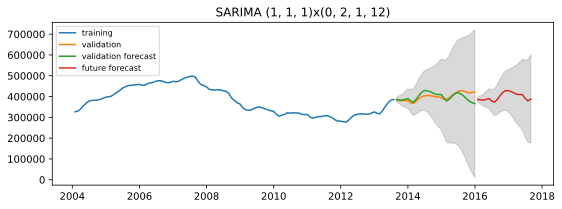

In [59]:
fc1, conf1 = model_d1_D2.predict(len(valid), return_conf_int=True, alpha=0.05)
fc2, conf2 = model_d1_D2.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=valid.index)
fc_series2 = pd.Series(fc2, index=test.index)

lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
lower_series2 = pd.Series(conf2[:, 0], index=test.index)
upper_series2 = pd.Series(conf2[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA (1, 1, 1)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [60]:
mse = ((fc_series1 - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

20606.54


### SARIMA (1, 1, 1) x (0, 2, 1, 12) Forecasting

In [61]:
train = sellprice_not_na
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [62]:
model_d1_D2_all = pm.auto_arima(train, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,  # seasonal lag = 12
                                start_P=0, seasonal=True,
                                d=1, D=2, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=2384.424, BIC=2398.320, Fit time=1.042 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=2495.035, BIC=2500.593, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=2505.690, BIC=2516.806, Fit time=0.230 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=2385.025, BIC=2396.141, Fit time=0.866 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=2392.310, BIC=2408.985, Fit time=1.421 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=2503.124, BIC=2514.241, Fit time=0.126 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=2397.503, BIC=2414.177, Fit time=1.085 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=2398.472, BIC=2417.926, Fit time=3.391 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=2376.470, BIC=2393.145, Fit time=1.616 seconds
Fit ARIMA: order=(2, 1, 0) s

In [63]:
model_d1_D2_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(2, 1, 0)x(0, 2, 1, 12)   Log Likelihood               -1177.917
Date:                            Tue, 10 Dec 2019   AIC                           2365.834
Time:                                    20:52:33   BIC                           2379.729
Sample:                                         0   HQIC                          2371.476
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.0557    108.516      0.314      0.754    -178.632     246.744
ar.L1          0.5190      0.100      5.178      0.000       0.323       0.715
ar.L2          0.1326      0.106      1.255      0.209      -0.074       0.340
ma.S.L12      -0.9992      0.121     -8.248      0.000      -1.237      -0.762
sigma2      2.168e+07   7.21e-06   3.01e+12      0.000    2.17e+07    2.17e+07
===================================================================================
Ljung-Box (Q):                       58.94   Jarque-Bera (JB):                 6.31
Prob(Q):                              0.03   Prob(JB):                         0.04
Heteroskedasticity (H):               0.80   Skew:                             0.44
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.79e+30. Standard errors may be unstable.
"""

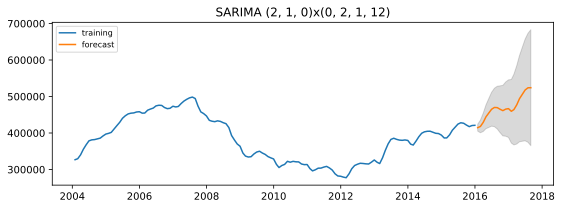

In [64]:
fc, conf = model_d1_D2_all.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series = pd.Series(fc, index=test.index)

lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('SARIMA (2, 1, 0)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Best SARIMA Log-Transformed Model

## Model selection with Auto-ARIMA

In [123]:
def create_training_splits(data, log=False):
    
    train_size = int(len(data) * 0.8)
    
    train = data[:train_size]
    valid = data[train_size:]
    
    # Hardcoded
    test = sellprice[sellprice.index >= pd.to_datetime('2016')] 
    
    if log: 
        return np.log(train), np.log(valid), np.log(test)
    else: 
        return train, valid, test

In [124]:
train, valid, test = create_training_splits(sellprice_not_na)

In [125]:
logtrain, logvalid, logtest = create_training_splits(sellprice_not_na, log=True)

In [126]:
fulldata = sellprice_not_na

In [127]:
logfull = np.log(fulldata)

### d = 1, D = 1

In [128]:
log_model_d1_D1 = pm.auto_arima(logtrain, start_p=1, start_q=1,
                                max_p=3, max_q=3, m=12,  # seasonal lag = 12
                                start_P=0, seasonal=True,
                                d=1, D=1, trace=True,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-608.710, BIC=-595.585, Fit time=0.562 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-554.393, BIC=-549.143, Fit time=0.045 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-605.739, BIC=-595.240, Fit time=0.709 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-584.396, BIC=-573.896, Fit time=0.528 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-604.697, BIC=-588.947, Fit time=1.271 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-600.551, BIC=-590.051, Fit time=0.085 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-609.149, BIC=-593.399, Fit time=2.353 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-583.165, BIC=-570.040, Fit time=0.470 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-607.876, BIC=-589.501, Fit time=1.628 seconds
Fit ARIMA: order=(1, 1, 0) s

In [129]:
log_model_d1_D1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 2, 12)   Log Likelihood                 310.116
Date:                            Tue, 10 Dec 2019   AIC                           -610.233
Time:                                    21:18:40   BIC                           -597.108
Sample:                                         0   HQIC                          -604.918
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.291      0.771      -0.001       0.001
ar.L1          0.6970      0.087      8.051      0.000       0.527       0.867
ma.S.L12      -0.4446      0.101     -4.398      0.000      -0.643      -0.246
ma.S.L24      -0.2000      0.116     -1.732      0.083      -0.426       0.026
sigma2         0.0001   1.75e-05      7.209      0.000    9.18e-05       0.000
===================================================================================
Ljung-Box (Q):                       31.97   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.81   Prob(JB):                         0.67
Heteroskedasticity (H):               2.37   Skew:                             0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

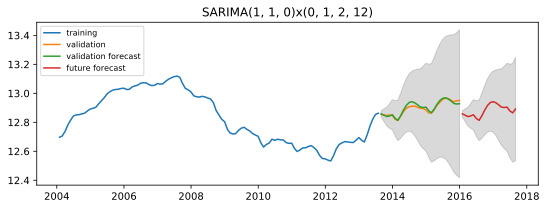

In [130]:
fc1, conf1 = log_model_d1_D1.predict(len(logvalid), return_conf_int=True, alpha=0.05)
fc2, conf2 = log_model_d1_D1.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=logvalid.index)
fc_series2 = pd.Series(fc2, index=logtest.index)

lower_series1 = pd.Series(conf1[:, 0], index=logvalid.index)
upper_series1 = pd.Series(conf1[:, 1], index=logvalid.index)
lower_series2 = pd.Series(conf2[:, 0], index=logtest.index)
upper_series2 = pd.Series(conf2[:, 1], index=logtest.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(logtrain, label='training')
plt.plot(logvalid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA(1, 1, 0)x(0, 1, 2, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [131]:
mse = ((fc_series1 - logvalid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

0.01


#### Transformed Back

In [132]:
mse = ((np.exp(fc_series1) - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

5640.62


### Training Model on Full Data

In [75]:
log_model_d1_D1_full = pm.auto_arima(logfull, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-802.044, BIC=-787.668, Fit time=0.962 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-727.661, BIC=-721.910, Fit time=0.029 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-794.993, BIC=-783.493, Fit time=0.598 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-773.964, BIC=-762.464, Fit time=1.094 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-794.465, BIC=-777.214, Fit time=0.946 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-786.570, BIC=-775.069, Fit time=0.106 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-807.914, BIC=-790.663, Fit time=1.953 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-779.186, BIC=-764.810, Fit time=1.001 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-805.601, BIC=-785.475, Fit time=1.077 seconds
Fit ARIMA: order=(1, 1, 0) s

In [76]:
log_model_d1_D1_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                 411.018
Date:                            Tue, 10 Dec 2019   AIC                           -808.035
Time:                                    20:55:27   BIC                           -787.909
Sample:                                         0   HQIC                          -799.857
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.524e-05      0.000     -0.115      0.908      -0.001       0.001
ar.L1          0.7312      0.134      5.437      0.000       0.468       0.995
ma.L1         -0.1675      0.157     -1.067      0.286      -0.475       0.140
ma.L2          0.0127      0.130      0.098      0.922      -0.243       0.268
ma.S.L12      -0.4833      0.100     -4.843      0.000      -0.679      -0.288
ma.S.L24      -0.2890      0.103     -2.796      0.005      -0.492      -0.086
sigma2         0.0001   1.22e-05      8.422      0.000    7.86e-05       0.000
===================================================================================
Ljung-Box (Q):                       50.11   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.13   Prob(JB):                         0.45
Heteroskedasticity (H):               1.08   Skew:                             0.08
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

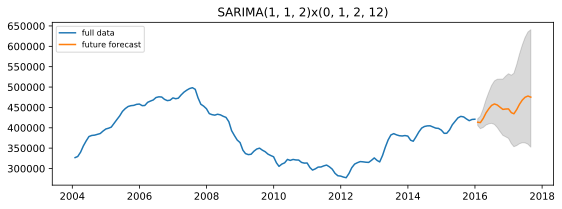

In [158]:
fc1, conf1 = log_model_d1_D1_full.predict(len(logtest), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(np.exp(fc1), index=logtest.index)

lower_series1 = np.exp(pd.Series(conf1[:, 0], index=logtest.index))
upper_series1 = np.exp(pd.Series(conf1[:, 1], index=logtest.index))


# Plot
plt.figure(figsize=(9, 3))
plt.plot(np.exp(logfull), label='full data')
plt.plot(fc_series1, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)

plt.title('SARIMA(1, 1, 2)x(0, 1, 2, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [84]:
zillow = pd.read_csv('../data/zillow-california.csv', index_col="Date", parse_dates=['Date'])
zillow.columns = ["Sold", "Mortgage", "Unemployment", "Rental"]

In [85]:
series = zillow.loc[~zillow.Sold.isnull(), "Sold"]
X = series.values

In [86]:
train_size = int(len(X) * 0.80)
train, test = series[:train_size], series[train_size:]

In [87]:
# SARIMAX
exog = zillow.loc[~zillow.Sold.isnull(), ["Unemployment"]]
exog_train = exog.iloc[:train_size]
exog_test = exog.iloc[train_size:]

In [89]:
#auto select orders
model = pm.auto_arima(train, exogenous=exog_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, 
                           start_P=0, seasonal=True,
                           d=1, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
model.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2362.736, BIC=2376.417, Fit time=0.089 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2362.689, BIC=2370.897, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=2384.163, BIC=2395.108, Fit time=0.030 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=2372.443, BIC=2383.388, Fit time=0.027 seconds
Total fit time: 0.159 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1178.344
Date:                Tue, 10 Dec 2019   AIC                           2362.689
Time:                        21:11:39   BIC                           2370.897
Sample:                             0   HQIC                          2366.020
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    507.5130    723.856      0.701      0.483    -911.219    1926.245
x1         -1981.9345   1127.184     -1.758      0.079   -4191.174     227.305
sigma2      5.566e+07   6.31e+06      8.820      0.000    4.33e+07     6.8e+07
===================================================================================
Ljung-Box (Q):                      279.73   Jarque-Bera (JB):                 6.64
Prob(Q):                              0.00   Prob(JB):                         0.04
Heteroskedasticity (H):               1.61   Skew:                            -0.37
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
modelx = SARIMAX(train, order=(1,1,3), exog=exog_train)
fitx = modelx.fit()
fitx.summary()

/Users/cheon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   Sold   No. Observations:                  115
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -1173.252
Date:                Tue, 10 Dec 2019   AIC                           2358.503
Time:                        21:11:55   BIC                           2374.920
Sample:                    01-31-2004   HQIC                          2365.166
                         - 07-31-2013                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Unemployment -1981.9342    673.124     -2.944      0.003   -3301.233    -662.635
ar.L1            0.9169      0.052     17.623      0.000       0.815       1.019
ma.L1           -0.8882      0.053    -16.887      0.000      -0.991      -0.785
ma.L2            0.0097      0.032      0.302      0.763      -0.053       0.073
ma.L3           -0.0058      0.030     -0.196      0.845      -0.064       0.053
sigma2         3.05e+07      0.064   4.76e+08      0.000    3.05e+07    3.05e+07
===================================================================================
Ljung-Box (Q):                      259.89   Jarque-Bera (JB):                13.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.89   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.88e+23. Standard errors may be unstable.
"""

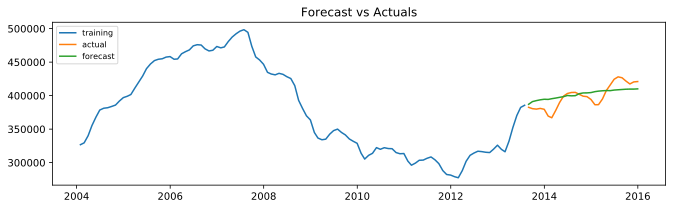

In [94]:
fc = fitx.predict(start='2013-08-31', end='2015-12-31', exog=exog_test)
fc_series = pd.Series(fc)
plt.figure(figsize=(11, 3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [95]:
mse = ((fc_series - test) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

13287.87


## Best VAR model

In [100]:
series = zillow.loc[~zillow.Sold.isnull(), ["Sold", "Unemployment"]]
train = series[:int(0.8*(len(series)))]
test = series[int(0.8*(len(series))):]

In [101]:
model = VAR(endog=train)
model_fit = model.fit(2)
model_fit.summary()

/Users/cheon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     21:13:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    16.1659
Nobs:                     113.000    HQIC:                   16.0225
Log likelihood:          -1210.42    FPE:                8.24119e+06
AIC:                      15.9245    Det(Omega_mle):     7.55758e+06
--------------------------------------------------------------------
Results for equation Sold
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const               -9722.775635     10029.597682           -0.969           0.332
L1.Sold                 1.666418         0.070202           23.737           0.000
L1.Unemployment       597.647046      1042.589206    

In [102]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
cols = series.columns
pred = pd.DataFrame(index=test.index,columns=[cols])
for j in range(0,2):
    for i in range(0, len(fc)):
        pred.iloc[i][j] = fc[i][j]

/Users/cheon/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


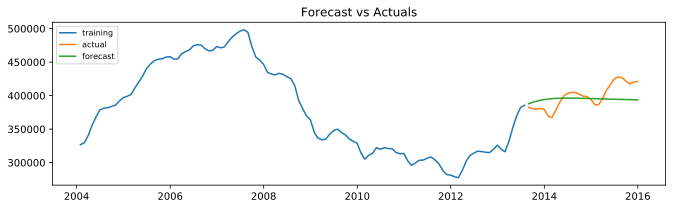

In [104]:
fc_series = pd.Series(fc[:, 0])
fc_series.index = test.Sold.index
plt.figure(figsize=(11, 3), dpi=100)
plt.plot(train.Sold, label='training')
plt.plot(test.Sold, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [105]:
fc_series = pd.Series(fc[:, 0])
mse = ((fc_series.values - test.Sold.values) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

17890.82


## Best ETS model

In [109]:
series = zillow.loc[~zillow.Sold.isnull(), "Sold"]
train_size = int(len(X) * 0.8)
train, test = series[:train_size], series[train_size:]
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12,damped=True)
model2 = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(len(test))
fit2 = model2.fit()
pred2 = fit2.forecast(len(test))

/Users/cheon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/cheon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/cheon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/cheon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


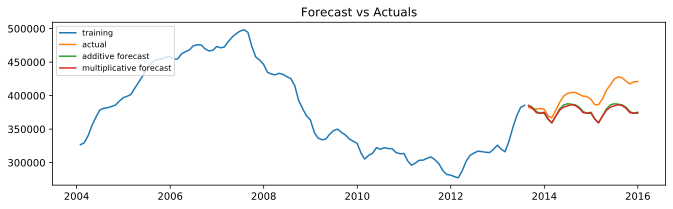

In [111]:
plt.figure(figsize=(11, 3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='additive forecast')
plt.plot(pred2, label='multiplicative forecast')
plt.title('Forecast vs Actuals')
# plt.plot(pred3, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [112]:
mse = ((pred.values - test.values) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

25716.92


## Residual diagnosis of best model (SARIMA log-transformed)

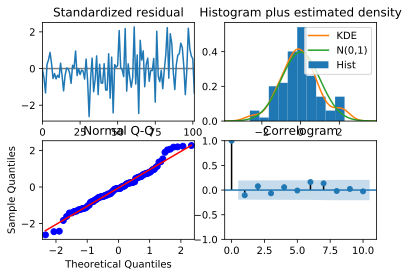

In [140]:
log_model_d1_D1.plot_diagnostics()
plt.show()

## Forecasted values

In [145]:
fc = log_model_d1_D1_full.predict(len(logtest), alpha=0.05)
forecast = pd.Series(np.exp(fc), index=logtest.index)

In [156]:
df_fc = pd.DataFrame(forecast, columns=['Forecast']).reset_index()
df_fc.to_csv('forecast.csv', index=False)

In [157]:
df_fc

,Date,Forecast
0,2016-01-31,413651.898387
1,2016-02-29,412685.450135
2,2016-03-31,422938.957362
3,2016-04-30,436394.177955
4,2016-05-31,446720.955040
5,2016-06-30,454935.640733
6,2016-07-31,458494.610616
7,2016-08-31,455975.101932
8,2016-09-30,450488.942672
9,2016-10-31,445109.547627
